# House Prices: Advanced Regression Techniques

### Description of the dataset
The data has been split into two groups:
- training set (train.csv) : SalePrice(response variable) with 79 explanatory variables
- test set (test.csv)

For detailed data description, check https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### The Objective
My goal is to predict the final price of each home using (almost) every aspect of residential homes in Ames, Iowa.

In [1]:
%matplotlib inline  
%config InlineBackend.figure_format='retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Import Dataset
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [3]:
train_set.shape, test_set.shape

((1460, 81), (1459, 80))

In [4]:
# Save 'Id' column
train_ID = train_set['Id']
test_ID = test_set['Id']

# Dropping 'Id' colum since it's unnecessary at the moment
train_set.drop("Id", axis = 1, inplace = True)
test_set.drop("Id", axis = 1, inplace = True)

In [5]:
train_set.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
ntrain, ntest = len(train_set), len(test_set)
# store response variable
y_train = train_set.SalePrice

# combining training and testing dataset
combined = pd.concat([train_set, test_set]).drop(['SalePrice'], axis=1).reset_index(drop=True)

print('Dimension of combined dataset is {}'.format(combined.shape))

Dimension of combined dataset is (2919, 79)


## Missing Values

In [7]:
def countNA(vector):
    count = 0
    for i in vector:
        if combined[i].isnull().sum() > 0:
            print(i, 'has', combined[i].isnull().sum(), 'missing values', '|', combined[i].dtype)
            count += 1
    if count == 0:
        print('There is no more missing values')

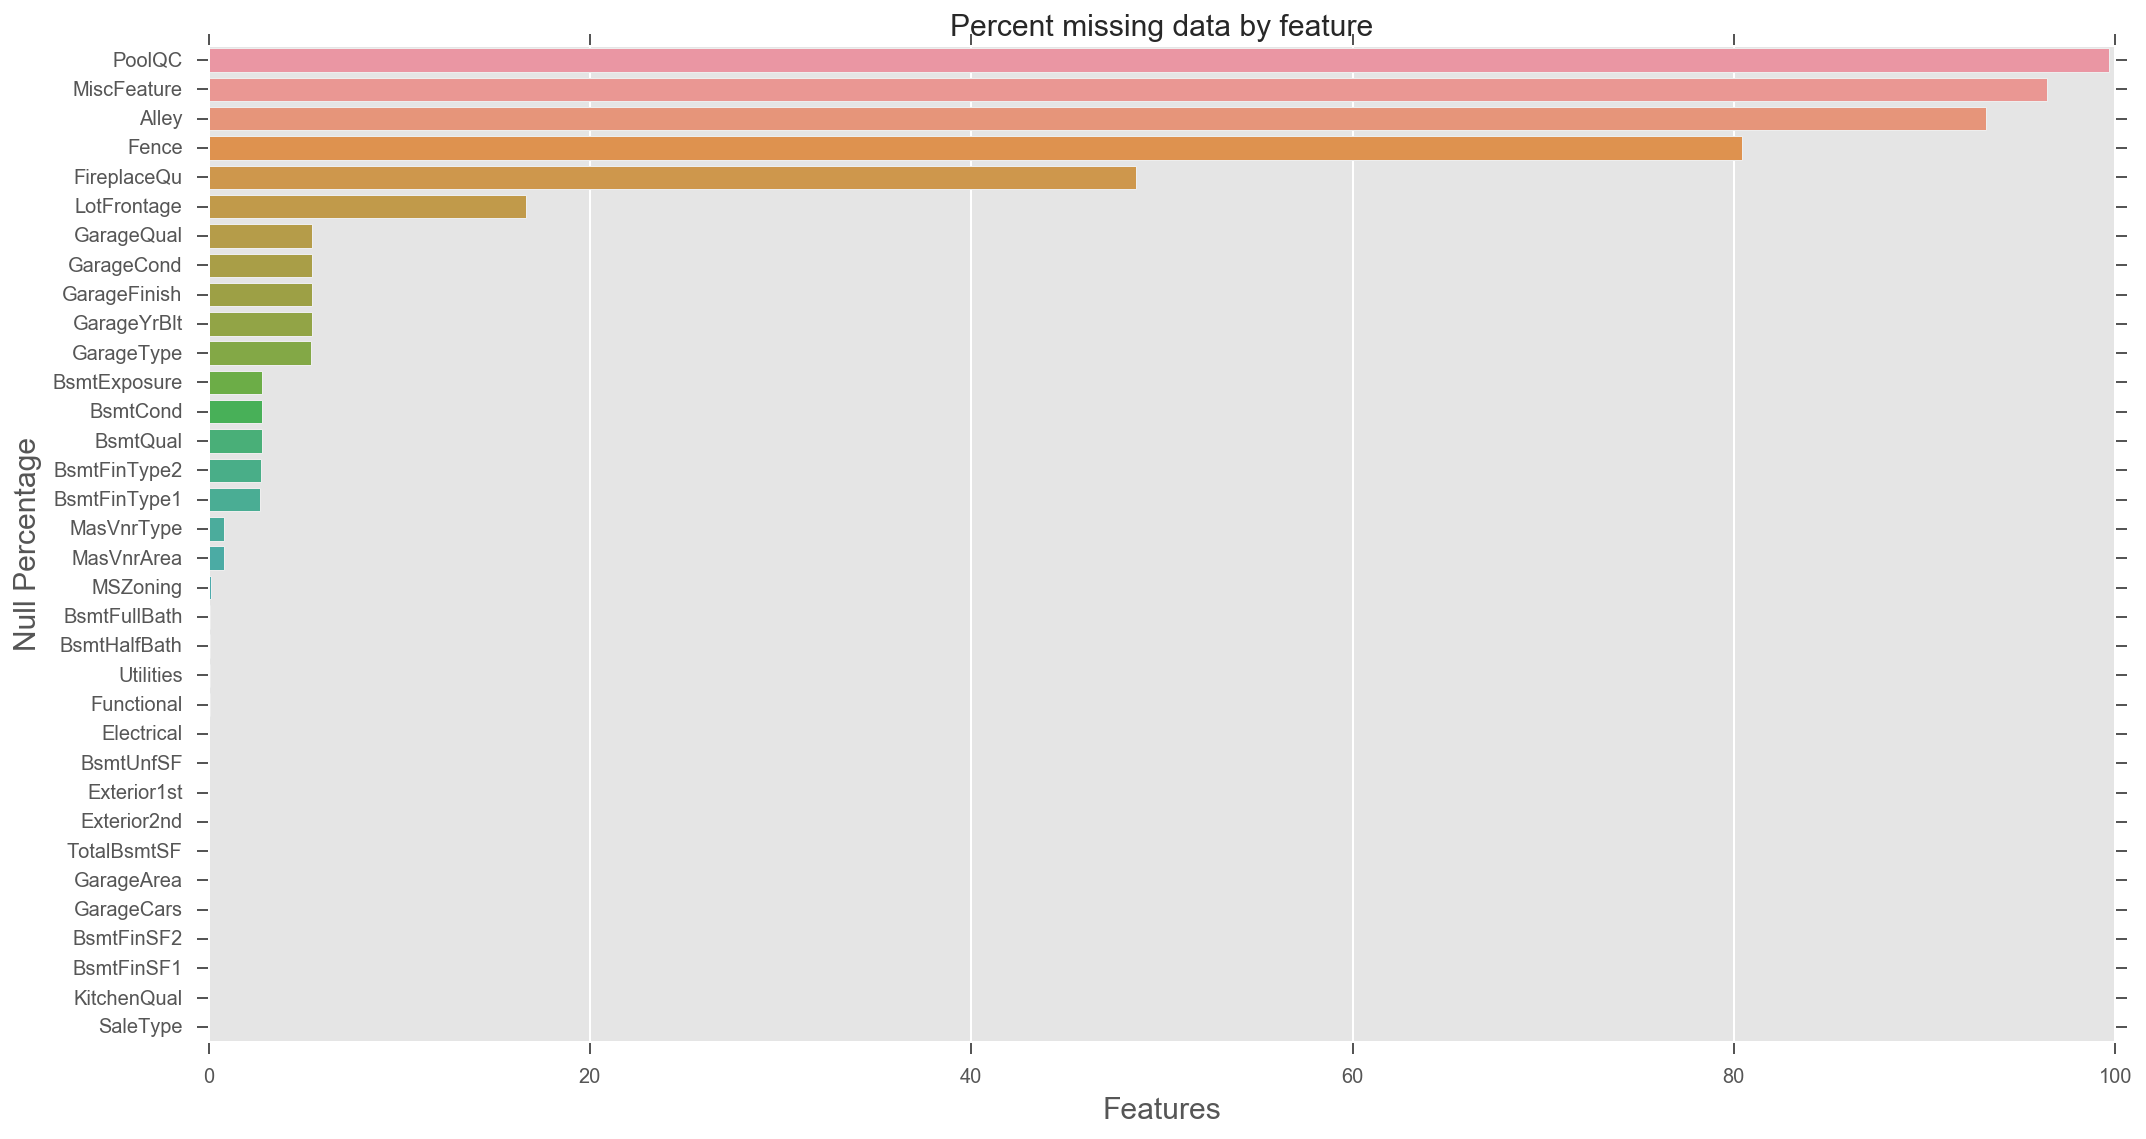

In [8]:
def Nullpc(df):    
    NAs = (df.isnull().sum() / len(combined)) * 100
    NAs = NAs.drop(NAs[NAs == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'NullRatio' : NAs}).T

    f, ax = plt.subplots(figsize=(15, 8))
    sns.barplot(x=NAs, y=NAs.index, orient='h')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Null Percentage', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    plt.tight_layout()
    
Nullpc(combined)

A lot of variables have missing values simply because of how they are recorded. For instance, PoolQC, a variable with the largest null percentage, is recorded NA if a certain house does not have a pool. Analogously, variables related to basement, garage, and miscellaneous feature are recorded as NA if a house does not have those features. Hence, NAs in those features will be replaced as 'None' for the further analysis. I will note that if some NAs does not indicate 'None' and make appropriate transformation.

### PoolQC and PoolArea
**PoolQC** is the variable with most number of NAs. According to the data description, NA indicates 'no pool' for a house.<br>
>  Ex:   Excellent <br> Gd:   Good <br> TA:   Average/Typical <br> Fa:   Fair <br> NA:   No Pool

So, I will fill in those NAs with 'None'.

In [9]:
combined.PoolQC.fillna('None', inplace = True)

**PoolArea** is a variable related to **PoolQC**. <br>
There might be NAs in PoolQC that does not mean 'no pool'. I will find those instances and assign different value to it. Since there is not much information regarding pool, I will refer to `OverallQual`ity of the house to estimate `PoolQC`. <br>
* `OverallQual` is scored from 1 to 10 and `PoolQC` is scored 0 to 4. 

In [10]:
combined[(combined.PoolQC == 0) & combined.PoolArea != 0].loc[:,['PoolQC', 'PoolArea', 'OverallQual']]

,PoolQC,PoolArea,OverallQual


In [11]:
combined.loc[2599, 'PoolQC'] = 2

### Miscellaneous Features
* **MiscFeature** is a variable with second most number of NAs. According to the data description, NA indicates 'None' for a house.<br>
> Elev: Elevator
  Gar2: 2nd Garage (if not described in garage section)
  Othr: Other
  Shed: Shed (over 100 SF)
  TenC: Tennis Court
  NA:   None
  
Let's fill in those NAs with 'None'.

In [12]:
combined.MiscFeature.fillna('None', inplace = True)

### Alley
* **Alley**.
>  **Grvl** : Gravel <br>
   **Pave** : Paved <br>
   **NA** :   No alley access
   
I will fill NAs with 'None'

In [13]:
combined.Alley.fillna('None', inplace = True)

### Fence
* **Fence**
> **GdPrv** :    Good Privacy <br>
  **MnPrv** :    Minimum Privacy <br>
  **GdWo** : Good Wood <br>
  **MnWw** : Minimum Wood/Wire <br>
  **NA** :   No Fence

I will fill those NAs with 'None'.

In [14]:
combined.Fence.fillna('None', inplace = True)

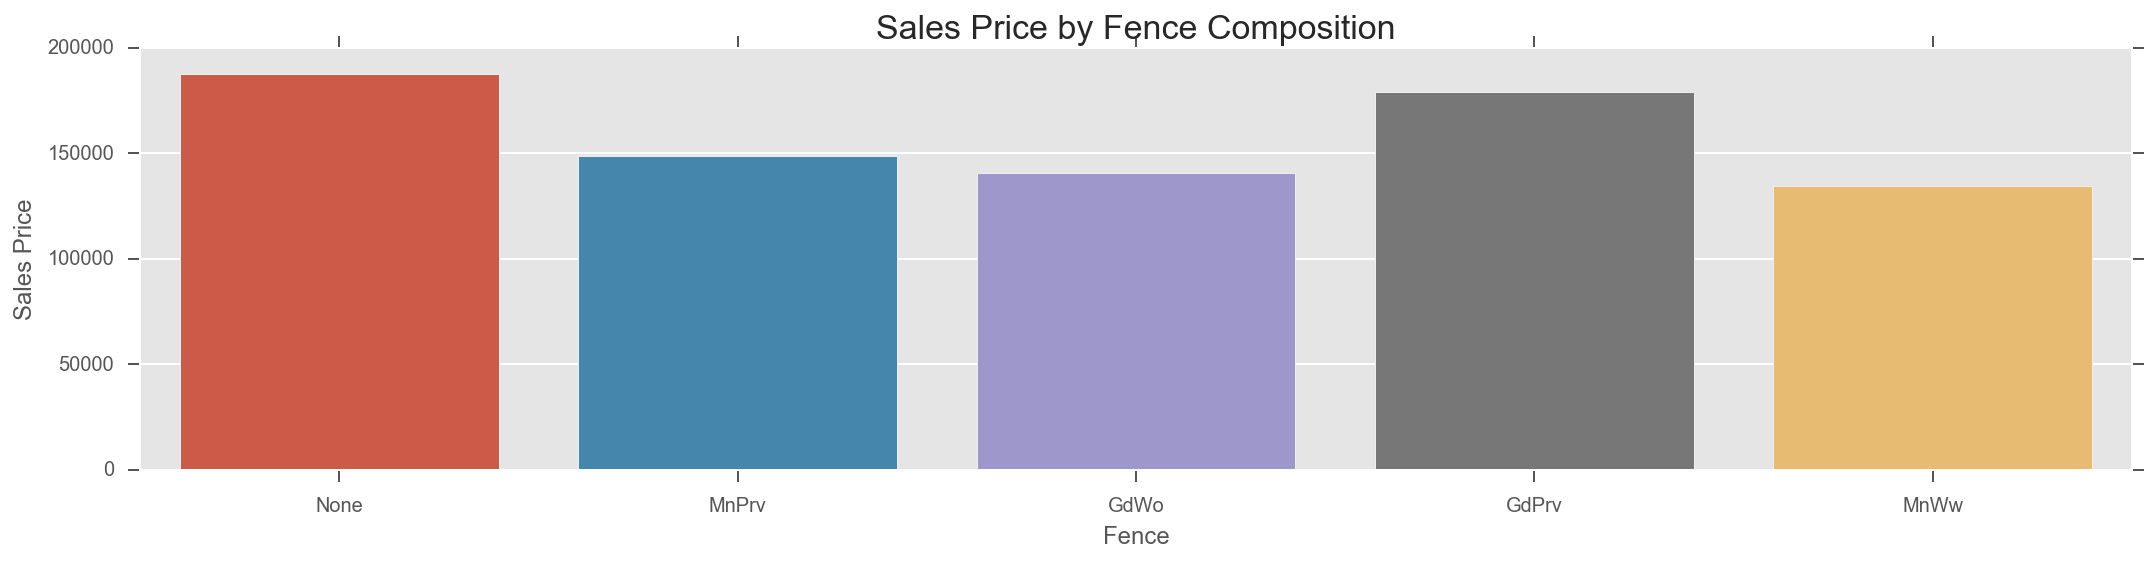

In [15]:
plt.subplots(figsize=(15, 4))
sns.barplot('Fence', y_train, data = combined, ci = False)
plt.xlabel('Fence', fontsize=12)
plt.ylabel('Sales Price', fontsize=12)
plt.title('Sales Price by Fence Composition', fontsize=17)
plt.tight_layout()

### FireplaceQu
* **FireplaceQu** 
>  **Ex**   Excellent - Exceptional Masonry Fireplace <br>
   **Gd**   Good - Masonry Fireplace in main level<br>
   **TA**   Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement<br>
   **Fa**   Fair - Prefabricated Fireplace in basement<br>
   **Po**   Poor - Ben Franklin Stove<br>
   **NA**   No Fireplace
   
If the number of `Fireplaces` in the house is zero, `FireplaceQu` has to be NA, vice versa. After checking that, it is safe to fill NAs with 'None'.

In [16]:
combined[(combined.FireplaceQu.isnull()) & (combined.Fireplaces != 0)].loc[:,['FireplaceQu','Fireplaces']]

,FireplaceQu,Fireplaces


In [17]:
combined[(combined.FireplaceQu.notnull()) & (combined.Fireplaces == 0)].loc[:,['FireplaceQu','Fireplaces']]

,FireplaceQu,Fireplaces


In [18]:
combined.FireplaceQu.fillna('None', inplace = True)

### Parking Lot Related Variables ( LotFrontage, LotShape, LotConfig )
* **LotFrontage**
Since `LotFrontage` is likely to vary across different neighborhoods, I will fill in NAs with Average `LotFrontage` by Neighborhood.

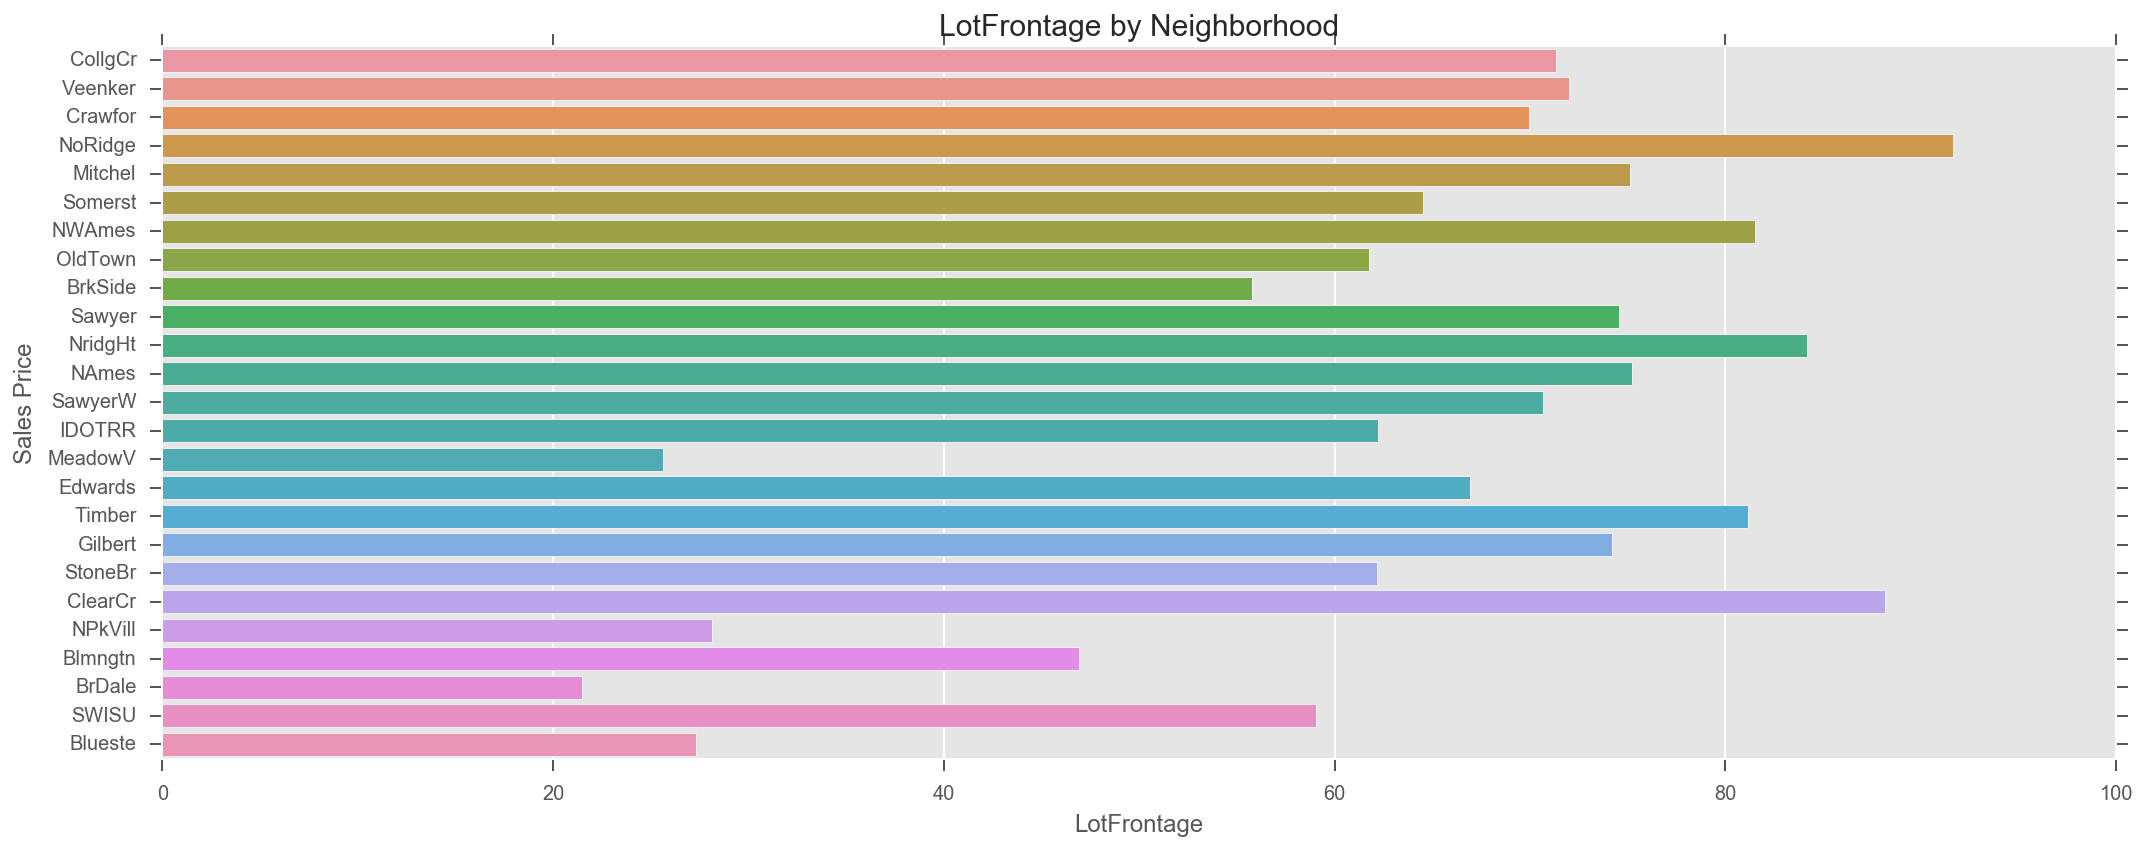

In [19]:
plt.subplots(figsize=(15, 6))
sns.barplot('LotFrontage', 'Neighborhood', data = combined, ci = False)
plt.xlabel('LotFrontage', fontsize=12)
plt.ylabel('Sales Price', fontsize=12)
plt.title('LotFrontage by Neighborhood', fontsize=15)
plt.tight_layout()

In [20]:
combined["LotFrontage"] = combined.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* **LotShape**: 0 Missing value.
> **Reg** : Regular <br>
   **IR1** : Slightly irregular <br>
   **IR2** : Moderately Irregular <br>
   **IR3** : Irregular
   
* **LotConfig** : 0 Missing value.
>  **Inside** : Inside lot <br>
   **Corner** : Corner lot <br>
   **CulDSac** : Cul-de-sac <br>
   **FR2** : Frontage on 2 sides of property <br>
   **FR3** : Frontage on 3 sides of property

In [21]:
countNA(['LotShape', 'LotConfig'])

There is no more missing values


### Garage Related Variables 

There are 7 garage related variable; **GarageArea, GarageCars, GarageCond, GarageFinish, GarageQual, GarageType, GarageYrBlt**

In [22]:
garageVar = ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt']
countNA(garageVar)

GarageArea has 1 missing values | float64
GarageCars has 1 missing values | float64
GarageCond has 159 missing values | object
GarageFinish has 159 missing values | object
GarageQual has 159 missing values | object
GarageType has 157 missing values | object
GarageYrBlt has 159 missing values | float64


* Categorical Variables : **GarageType, GarageFinish, GarageQual, GarageCond** <br>
* Continuous Variables : **GarageArea, GarageCars** <br>

(**GarageYrBlt** has integer but is actually a categorical variable. I will check if data are stored as object.) <br>

For categorical variables, NAs indicates 'None'. There are 157 NAs in `GarageType` while other categorical variables have 159. First, let's confirm that the NAs in the three variables are pointing to the same observations and then find two NAs that doesn't acutally mean 'None'.

In [23]:
len(combined[(combined['GarageFinish'].isnull()) & (combined['GarageQual'].isnull()) & (combined['GarageCond'].isnull())])

159

In [24]:
combined[(combined['GarageType'].notnull()) & combined['GarageFinish'].isnull()].loc[:,garageVar]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2126,360.0,1.0,NaN,NaN,NaN,Detchd,NaN
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


First row above shows that NAs does not mean 'No Garage'. So, I will change those missing values with the most frequent values in each variables. However, it is more probable to assume 'No Garage' for the second observation since all of the variable except `GarageType` are NAs. So, for second observation, I will assign zeros for `GarageArea`, `GarageCars` and NA to `GarageType`. Then I convert all the NAs of garage related categorical variables to 'None'.

In [25]:
garageVar = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
combined.GarageType[2576] = np.NaN
combined.loc[2576,['GarageArea','GarageCars']] = 0

for var in garageVar:
    combined.loc[2126, var] = combined[var].mode()[0]
    combined[var].fillna('None', inplace = True)

In [26]:
for var in garageVar:
    print(var, ':',combined[var].unique())

GarageType : ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
GarageFinish : ['RFn' 'Unf' 'Fin' 'None']
GarageQual : ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageCond : ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']


* **GarageYrBlt**

In [27]:
combined.GarageYrBlt[combined.GarageYrBlt.isnull()] = combined.YearBuilt[combined.GarageYrBlt.isnull()]

### **Basement Related Variables**

There are 11 basement related variables; **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtFullBath, BsmtFullBath, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF** <br><br>

* Categorical Variables: **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2** <br>
* Numerical Variables: **BsmtFullBath, BsmtFullBath, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF**


> If a house does not have basement, categorical and numerical variables related to basement should also have null values and zeros respectively. 

In [28]:
bsmtCat_Var = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
bsmtNum_Var = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

countNA(bsmtCat_Var), countNA(bsmtNum_Var)

BsmtQual has 81 missing values | object
BsmtCond has 82 missing values | object
BsmtExposure has 82 missing values | object
BsmtFinType1 has 79 missing values | object
BsmtFinType2 has 80 missing values | object
BsmtFullBath has 2 missing values | float64
BsmtHalfBath has 2 missing values | float64
BsmtFinSF1 has 1 missing values | float64
BsmtFinSF2 has 1 missing values | float64
BsmtUnfSF has 1 missing values | float64
TotalBsmtSF has 1 missing values | float64


(None, None)

Similar to garage related variables, there are different number of NAs in categorical variables which means some of the NAs does not indicate 'No Basement'. I will identify them first and impute those with the most frequent values in each variable. For `BsmtQual` and `BsmtCond`, I will assign certain scores referring to `OverallQual`ity of the house.<br>

There are 79 NAs that indicate 'No Basement'. Rest of the NAs in categorical variables does not indicate 'No Basement'.

In [29]:
len(combined[(combined.BsmtQual.isnull()) & (combined.BsmtCond.isnull()) & (combined.BsmtExposure.isnull()) & 
         (combined.BsmtFinType1.isnull()) & (combined.BsmtFinType2.isnull())])

79

In [30]:
combined[(combined.BsmtFinType1.notnull()) & ((combined.BsmtCond.isnull()) | (combined.BsmtExposure.isnull()) | 
         (combined.BsmtQual.isnull()) | (combined.BsmtFinType2.isnull()))].loc[:,bsmtCat_Var]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,NaN
948,Gd,TA,NaN,Unf,Unf
1487,Gd,TA,NaN,Unf,Unf
2040,Gd,NaN,Mn,GLQ,Rec
2185,TA,NaN,No,BLQ,Unf
2217,NaN,Fa,No,Unf,Unf
2218,NaN,TA,No,Unf,Unf
2348,Gd,TA,NaN,Unf,Unf
2524,TA,NaN,Av,ALQ,Unf


In [31]:
combined.loc[2217:2218, ['BsmtQual','OverallQual']]

,BsmtQual,OverallQual
2217,NaN,4
2218,NaN,4


In [32]:
combined.BsmtQual[2217:2218] = 'Fa'
combined.BsmtCond[[2040,2185,2524]] = 'TA'
combined.BsmtExposure[[948,1487,2348]] = combined.BsmtExposure.mode()[0]
combined.BsmtFinType2[332] = combined.BsmtFinType2.mode()[0]

In [33]:
for var in bsmtCat_Var:
    combined[var].fillna('None', inplace = True)
    print(var, ':',combined[var].unique())

BsmtQual : ['Gd' 'TA' 'Ex' 'None' 'Fa']
BsmtCond : ['TA' 'Gd' 'None' 'Fa' 'Po']
BsmtExposure : ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1 : ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2 : ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']


Numerical Variables

In [34]:
for var in bsmtNum_Var:
    combined[combined.BsmtQual == 0].loc[:,var].fillna(0, inplace = True)
    
combined[(combined.BsmtFullBath.isnull()) | (combined.BsmtHalfBath.isnull()) |
         (combined.BsmtFinSF1.isnull()) | (combined.BsmtFinSF2.isnull()) |
         (combined.BsmtUnfSF.isnull()) | (combined.TotalBsmtSF.isnull())].loc[:,['BsmtFullBath','BsmtHalfBath',
                                                                                 'BsmtFinSF1', 'BsmtFinSF2',
                                                                                 'BsmtUnfSF', 'TotalBsmtSF','BsmtQual']]

,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtQual
2120,NaN,NaN,NaN,NaN,NaN,NaN,None
2188,NaN,NaN,0.0,0.0,0.0,0.0,None


In [35]:
for var in bsmtNum_Var:
    combined.loc[[2120,2188], var] = 0
    
countNA(bsmtCat_Var), countNA(bsmtNum_Var)

There is no more missing values
There is no more missing values


(None, None)

### Masonry Veneer Related Variables (  MasVnrType, MasVnrArea )

* Categorical Variable : MasVnrType
> **BrkCmn** : Brick Common <br>
  **BrkFace** : Brick Face <br>
  **CBlock** : Cinder Block <br>
  **None** : None <br>
  **Stone** : Stone

* Continuous Variable : MasVnrArea

There are 24 NAs in `MasVnrType` while there are 23 NAs in `MasVnrArea`. There is at least 1 NA that does not imply 'None'. I will identify that and impute with the most frequent value in `MasVnrType` that is not 'None'. Then, I will fill in with 'None' and zeros for the rest of 23 NAs in `MasVnrType` and `MasVnrArea`.

In [36]:
masVnr_var = ['MasVnrType', 'MasVnrArea']
countNA(masVnr_var)

MasVnrType has 24 missing values | object
MasVnrArea has 23 missing values | float64


In [37]:
combined[(combined.MasVnrType.isnull()) & (combined.MasVnrArea.notnull())].loc[:,masVnr_var]

,MasVnrType,MasVnrArea
2610,NaN,198.0


In [38]:
combined.MasVnrType[2610] = combined.MasVnrType[combined.MasVnrType != 'None'].mode()[0]

In [39]:
combined.MasVnrType.fillna('None', inplace = True)
combined.MasVnrArea.fillna(0, inplace = True)
countNA(masVnr_var)

There is no more missing values


### MSZoning

There are 4 NAs in `MSZoning`. I will impute those with the most frequent values in the variable. 

In [40]:
countNA(['MSZoning'])

MSZoning has 4 missing values | object


In [41]:
combined.MSZoning.fillna(combined.MSZoning.mode()[0], inplace = True)
countNA(['MSZoning'])

There is no more missing values


### Kitchen Related Variables ( Kitchen, KitchenQual )  
There is 1 NA in `KitchenQual`. I will impute it with the most frequent value in the variable.

In [42]:
kitchenVar = ['KitchenAbvGr', 'KitchenQual']
countNA(kitchenVar)

KitchenQual has 1 missing values | object


In [43]:
combined.KitchenQual.fillna(combined.KitchenQual.mode()[0], inplace = True)
countNA(kitchenVar)

There is no more missing values


### Utilities
There are 2 NAs in `Utilities`. However, all the houses have access to all public utilities except one which means `Utilities` variable is not very useful for the analysis. Hence, I will rather drop the variable now. 

In [44]:
countNA(['Utilities'])

Utilities has 2 missing values | object


In [45]:
combined.Utilities.value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [46]:
combined.drop('Utilities', axis = 1, inplace = True)

### Functional
There are 2 NAs in `Functional`. I will impute those with the most frequent values in the variable. 

In [47]:
countNA(['Functional'])

Functional has 2 missing values | object


In [48]:
combined.Functional.fillna(combined.Functional.mode()[0], inplace = True)

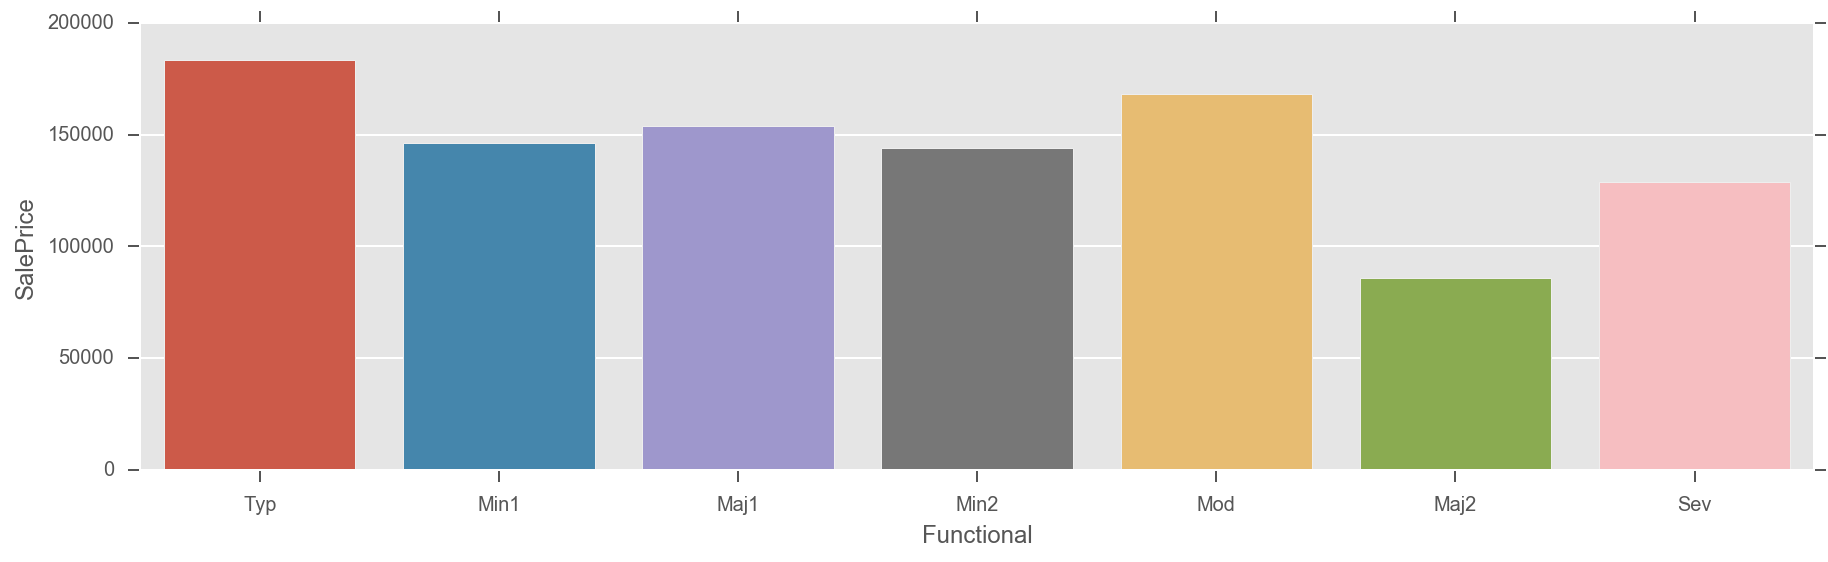

In [49]:
plt.subplots(figsize=(15, 4))
sns.barplot('Functional', y_train, data = combined, ci = False)

### Exterior Related Variables ( Exterior1st, Exterior2nd, ExterQual, ExterCond )
There are 4 Exterior related categorical variables. <br>
There are one NA in each `Exterior1st` and `Exterior2nd`. I will impute those with the most frequent values in each variable.

In [50]:
exterVar = ['Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']
countNA(exterVar)

Exterior1st has 1 missing values | object
Exterior2nd has 1 missing values | object


In [51]:
combined.Exterior1st.fillna(combined.Exterior1st.mode()[0], inplace = True)
combined.Exterior2nd.fillna(combined.Exterior2nd.mode()[0], inplace = True)
countNA(exterVar)

There is no more missing values


### Electrical 
There is one NA in `Electrical`. I will impute it with the most frequent value in the variable.

In [52]:
countNA(['Electrical'])

Electrical has 1 missing values | object


In [53]:
combined.Electrical.fillna(combined.Electrical.mode()[0], inplace = True)
countNA(['Electrical'])

There is no more missing values


### Sale Related Variables ( SaleType, SaleCondition )
There is one NA in `SaleType`. I will impute it with the most frequent value in the variable. 

In [54]:
saleVar = ['SaleType', 'SaleCondition']
countNA(saleVar)

SaleType has 1 missing values | object


In [55]:
combined.SaleType.fillna(combined.SaleType.mode()[0], inplace = True)
countNA(saleVar)

There is no more missing values


In [56]:
countNA(combined.columns)

There is no more missing values


In [57]:
train_set = combined[:ntrain]
train_set = pd.concat([train_set, y_train], axis = 1)
train_set = pd.concat([train_ID, train_set], axis = 1)
        
test_set = combined[ntrain:].reset_index(drop=True)
test_set = pd.concat([test_ID, test_set], axis = 1)

In [58]:
train_set.head(2)

,Id,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,1,856,854,0,None,3,1Fam,TA,No,706.0,...,WD,0,Pave,8,856.0,0,2003,2003,2008,208500
1,2,1262,0,0,None,3,1Fam,TA,Gd,978.0,...,WD,0,Pave,6,1262.0,298,1976,1976,2007,181500


In [59]:
test_set.head(2)

,Id,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,1461,896,0,0,None,2,1Fam,TA,No,468.0,...,Normal,WD,120,Pave,5,882.0,140,1961,1961,2010
1,1462,1329,0,0,None,3,1Fam,TA,No,923.0,...,Normal,WD,0,Pave,6,1329.0,393,1958,1958,2010


In [60]:
train_set.to_csv('train(cleaned).csv', index = False)
test_set.to_csv('test(cleaned).csv', index = False)